In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import math

In [3]:
%run football_data_api.py

In [4]:
seasons = FootballData().soccerseason.all()

In [5]:
premier_league_season = filter(lambda x: x.league == 'PL', seasons)[0]

In [6]:
fixtures = premier_league_season.fixtures

In [7]:
league_table = premier_league_season.leagueTable

In [8]:
team_cache = dict()

def get_team_by_id(id):
    if id in team_cache:
        return team_cache[id]
    else:
        team = FootballData().teams(id)
        team_cache[id] = team
        return team

def get_teams(fixture):
    home_team_id = fixture._extract_id_from_link(fixture.data['_links']['homeTeam']['href'])
    away_team_id = fixture._extract_id_from_link(fixture.data['_links']['awayTeam']['href'])
    return (get_team_by_id(home_team_id), get_team_by_id(away_team_id))
    

In [9]:
def fill_cache():
    for f in fixtures:
        get_teams(f)
fill_cache()

In [10]:
rows = []
team_index = []
teams = []
for k, v in team_cache.iteritems():
    team_index.append(k)
    teams.append([v.code, len(team_index) - 1])
teams = pd.DataFrame(teams, columns=['team', 'i'])

for f in fixtures:
    home_team, away_team = get_teams(f)
    home_score = f.result.goalsHomeTeam
    away_score = f.result.goalsAwayTeam
    rows.append([home_team.code, away_team.code, home_score, away_score,
                 team_index.index(home_team.id), team_index.index(away_team.id)])
df = pd.DataFrame(rows, columns = ['home', 'away', 'home_score', 'away_score', 'i_home', 'i_away'])

In [11]:
df.head()

,home,away,home_score,away_score,i_home,i_away
0,MUFC,SWA,1,2,2,7
1,WBA,SUN,2,2,9,6
2,QPR,HUL,0,1,4,11
3,WHU,THFC,0,1,14,8
4,SCFC,AVFC,0,1,5,17


In [12]:
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values
home_team = df.i_home.values
away_team = df.i_away.values
num_teams = len(df.i_home.unique())
num_games = len(home_team)

In [13]:
g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())

In [14]:
home = pm.Normal('home', 0, .0001, value=0)
tau_att = pm.Gamma('tau_att', .1, .1, value=10)
tau_def = pm.Gamma('tau_def', .1, .1, value=10)
intercept = pm.Normal('intercept', 0, .0001, value=0)

#team-specific parameters
atts_star = pm.Normal("atts_star", 
                        mu=0, 
                        tau=tau_att, 
                        size=num_teams, 
                        value=att_starting_points.values)
defs_star = pm.Normal("defs_star", 
                        mu=0, 
                        tau=tau_def, 
                        size=num_teams, 
                        value=def_starting_points.values)

In [15]:
@pm.deterministic
def atts(atts_star=atts_star):
    atts = atts_star.copy()
    atts = atts - np.mean(atts_star)
    return atts

@pm.deterministic
def defs(defs_star=defs_star):
    defs = defs_star.copy()
    defs = defs - np.mean(defs_star)
    return defs

@pm.deterministic
def home_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept + 
                  home + 
                  atts[home_team] + 
                  defs[away_team])
  
@pm.deterministic
def away_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept + 
                  atts[away_team] + 
                  defs[home_team])   


home_goals = pm.Poisson('home_goals', 
                          mu=home_theta, 
                          value=observed_home_goals, 
                          observed=True)
away_goals = pm.Poisson('away_goals', 
                          mu=away_theta, 
                          value=observed_away_goals, 
                          observed=True)

In [16]:
mcmc = pm.MCMC([home, intercept, tau_att, tau_def, 
                  home_theta, away_theta, 
                  atts_star, defs_star, atts, defs, 
                  home_goals, away_goals])
map_ = pm.MAP(mcmc)
map_.fit()
mcmc.sample(200000, 40000, 20)

 [-----------------100%-----------------] 200000 of 200000 complete in 90.4 sec

Plotting home


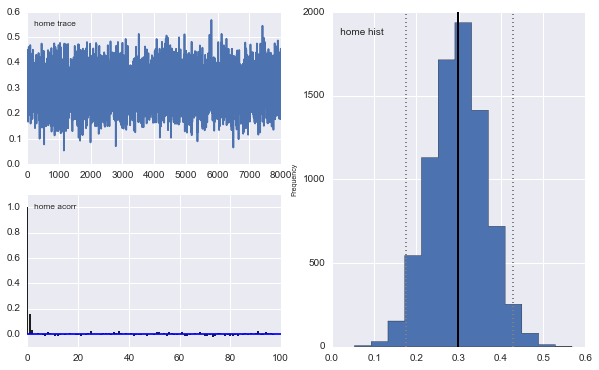

In [17]:
pm.Matplot.plot(home)

In [18]:
def simulate_season():
    """
    Simulate a season once, using one random draw from the mcmc chain. 
    """
    num_samples = atts.trace().shape[0]
    draw = np.random.randint(0, num_samples)
    atts_draw = pd.DataFrame({'att': atts.trace()[draw, :],})
    defs_draw = pd.DataFrame({'def': defs.trace()[draw, :],})
    home_draw = home.trace()[draw]
    intercept_draw = intercept.trace()[draw]
    season = df.copy()
    season = pd.merge(season, atts_draw, left_on='i_home', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_home', right_index=True)
    season = season.rename(columns = {'att': 'att_home', 'def': 'def_home'})
    season = pd.merge(season, atts_draw, left_on='i_away', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_away', right_index=True)
    season = season.rename(columns = {'att': 'att_away', 'def': 'def_away'})
    season['home'] = home_draw
    season['intercept'] = intercept_draw
    season['home_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['home'] + 
                                                           x['att_home'] + 
                                                           x['def_away']), axis=1)
    season['away_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['att_away'] + 
                                                           x['def_home']), axis=1)
    season['home_goals'] = season.apply(lambda x: np.random.poisson(x['home_theta']), axis=1)
    season['away_goals'] = season.apply(lambda x: np.random.poisson(x['away_theta']), axis=1)
    season['home_outcome'] = season.apply(lambda x: 'win' if x['home_goals'] > x['away_goals'] else 
                                                    'loss' if x['home_goals'] < x['away_goals'] else 'draw', axis=1)
    season['away_outcome'] = season.apply(lambda x: 'win' if x['home_goals'] < x['away_goals'] else 
                                                    'loss' if x['home_goals'] > x['away_goals'] else 'draw', axis=1)
    season = season.join(pd.get_dummies(season.home_outcome, prefix='home'))
    season = season.join(pd.get_dummies(season.away_outcome, prefix='away'))
    return season


def create_season_table(season):
    """
    Using a season dataframe output by simulate_season(), create a summary dataframe with wins, losses, goals for, etc.
    
    """
    g = season.groupby('i_home')    
    home = pd.DataFrame({'home_goals': g.home_goals.sum(),
                         'home_goals_against': g.away_goals.sum(),
                         'home_wins': g.home_win.sum(),
                         'home_draws': g.home_draw.sum(),
                         'home_losses': g.home_loss.sum()
                         })
    g = season.groupby('i_away')    
    away = pd.DataFrame({'away_goals': g.away_goals.sum(),
                         'away_goals_against': g.home_goals.sum(),
                         'away_wins': g.away_win.sum(),
                         'away_draws': g.away_draw.sum(),
                         'away_losses': g.away_loss.sum()
                         })
    df = home.join(away)
    df['wins'] = df.home_wins + df.away_wins
    df['draws'] = df.home_draws + df.away_draws
    df['losses'] = df.home_losses + df.away_losses
    df['points'] = df.wins * 3 + df.draws
    df['gf'] = df.home_goals + df.away_goals
    df['ga'] = df.home_goals_against + df.away_goals_against
    df['gd'] = df.gf - df.ga
    df = pd.merge(teams, df, left_on='i', right_index=True)
    df = df.sort_index(by='points', ascending=False)
    df = df.reset_index()
    df['position'] = df.index + 1
    df['champion'] = (df.position == 1).astype(int)
    df['qualified_for_CL'] = (df.position < 5).astype(int)
    df['relegated'] = (df.position > 17).astype(int)
    return df  
    
def simulate_seasons(n=100):
    dfs = []
    for i in range(n):
        s = simulate_season()
        t = create_season_table(s)
        t['iteration'] = i
        dfs.append(t)
    return pd.concat(dfs, ignore_index=True)

In [19]:
simuls = simulate_seasons(1000)

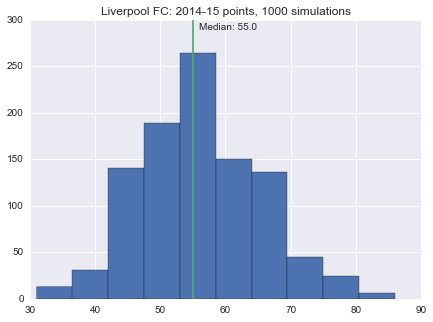

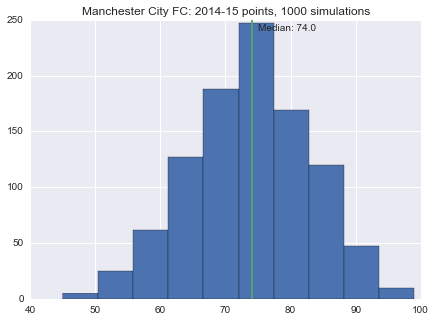

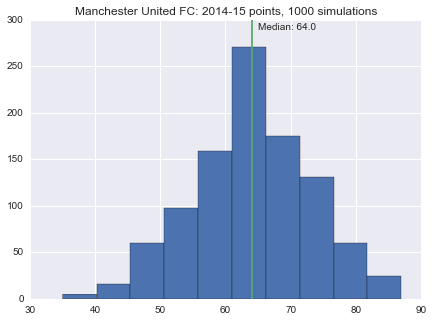

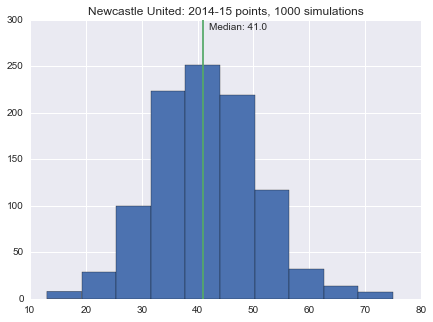

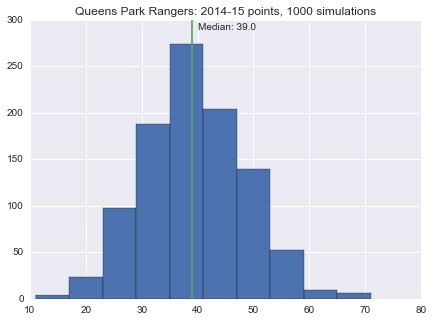

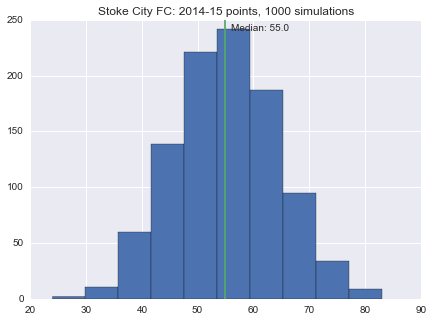

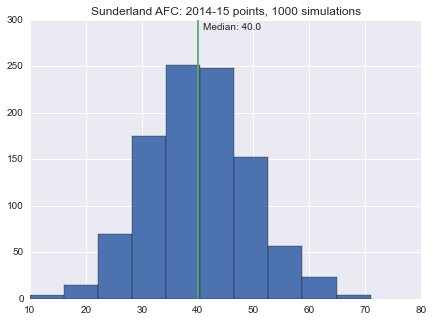

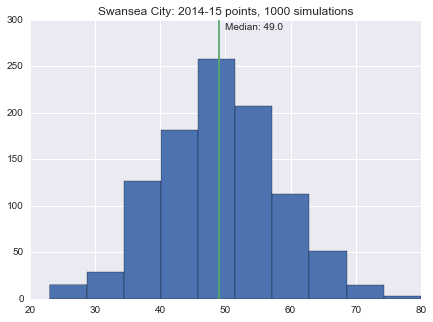

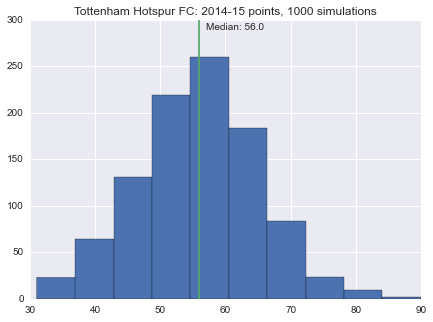

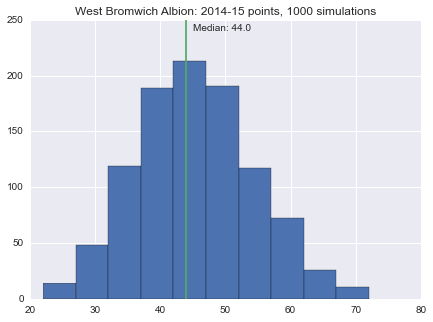

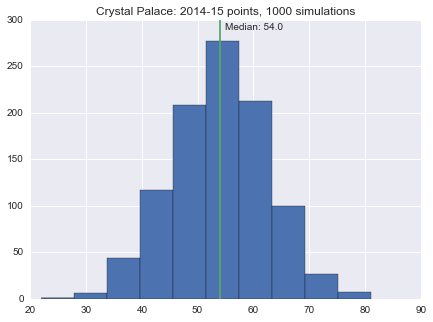

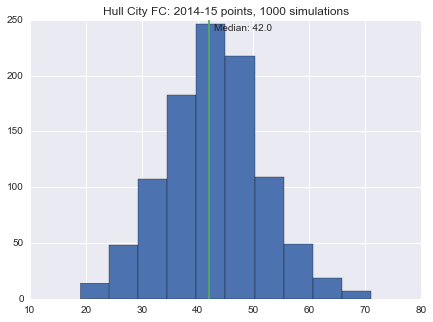

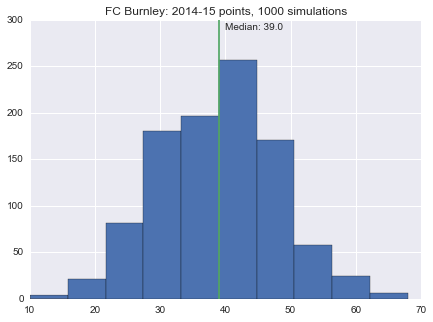

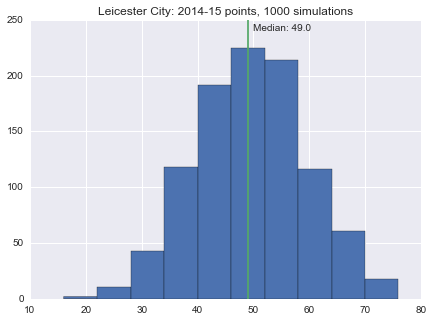

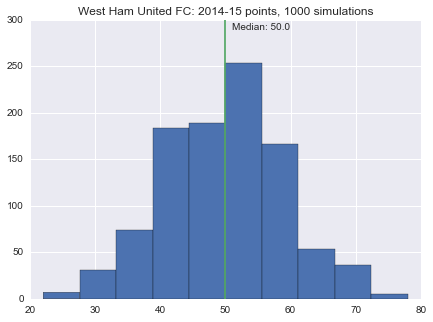

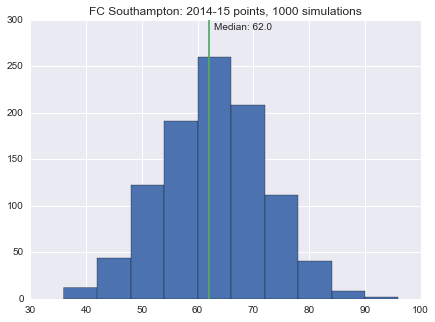

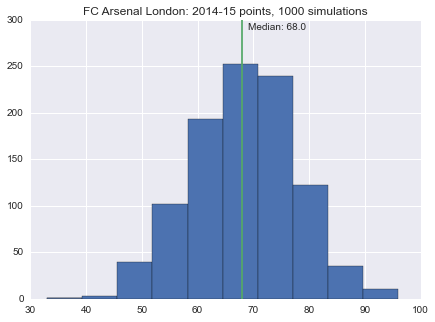

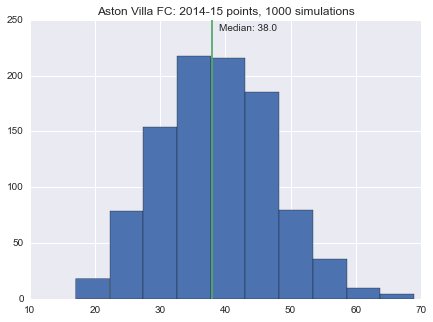

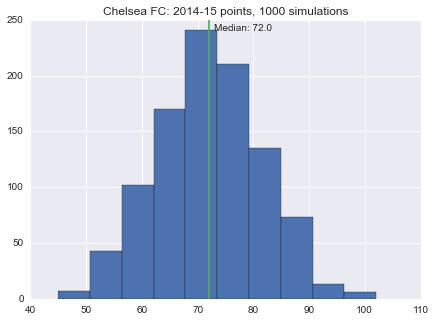

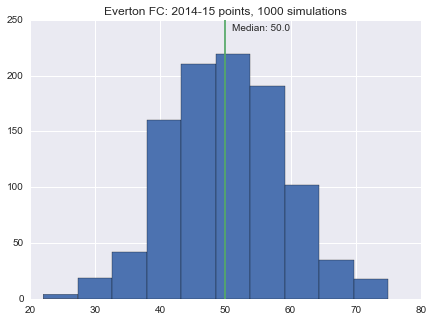

In [20]:
for team_code in teams.team.unique():
    plt.figure()
    ax = simuls.points[simuls.team == team_code].hist(figsize=(7,5))
    median = simuls.points[simuls.team == team_code].median()
    team_id = team_index[teams[teams.team == team_code].i.values[0]]
    team = get_team_by_id(team_id)
    ax.set_title(team.name + ': 2014-15 points, 1000 simulations')
    ax.plot([median, median], ax.get_ylim())
    plt.annotate('Median: %s' % median, xy=(median + 1, ax.get_ylim()[1]-10))

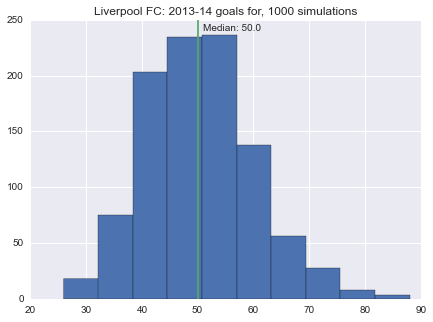

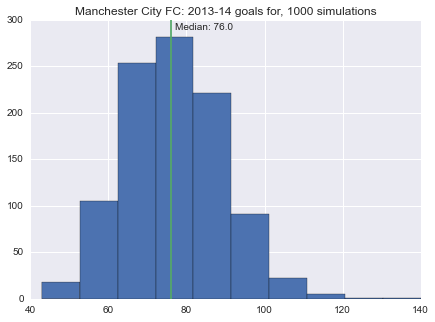

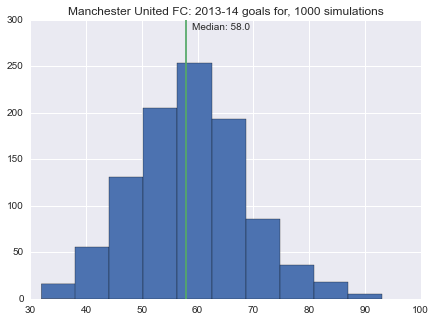

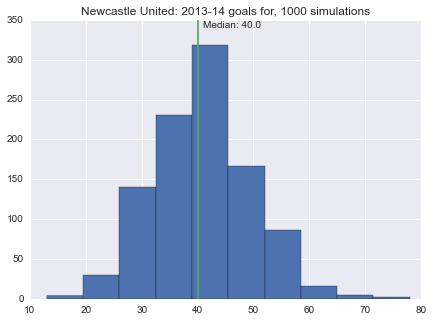

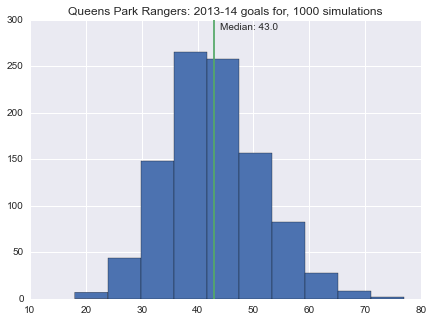

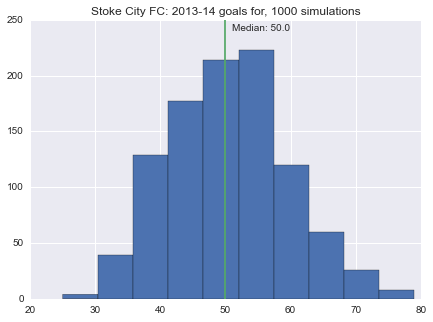

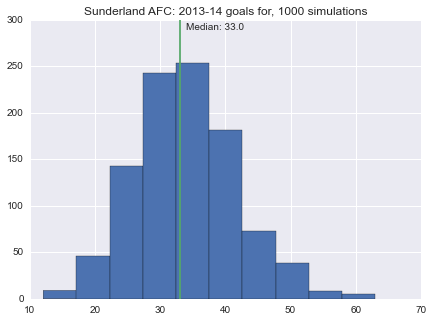

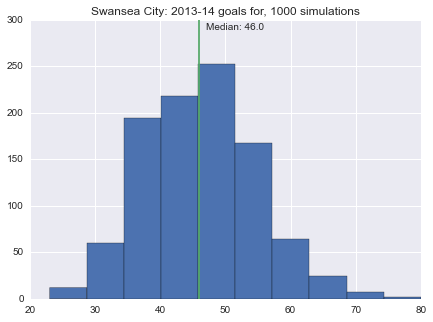

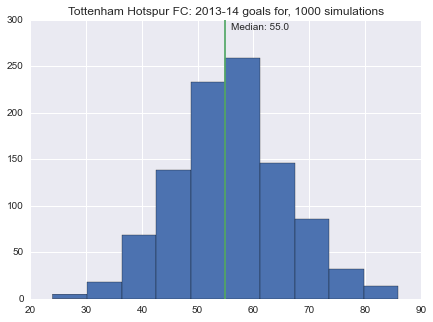

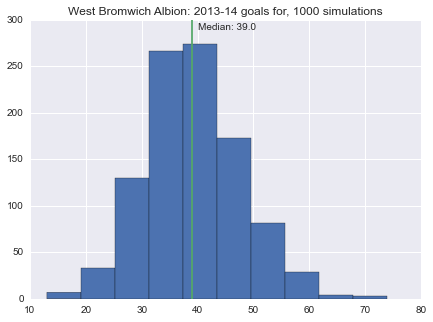

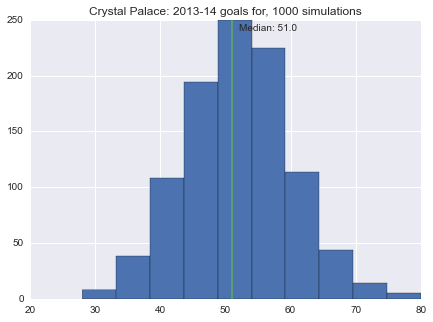

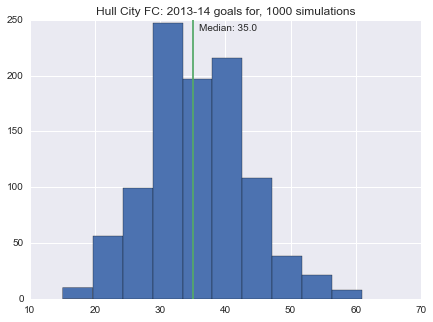

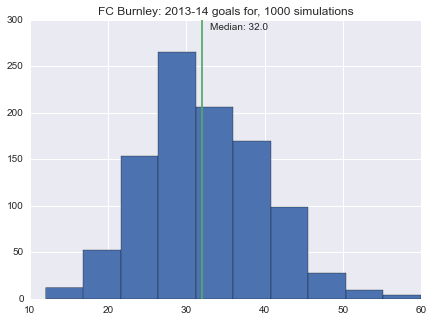

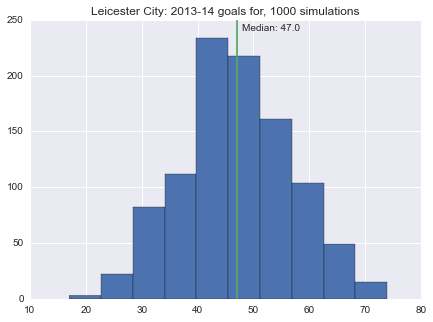

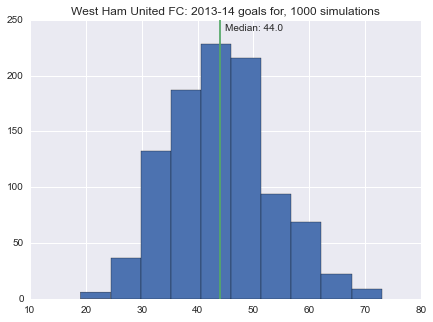

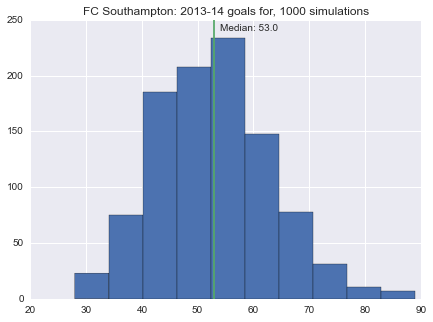

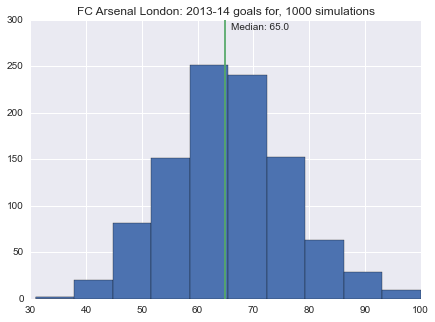

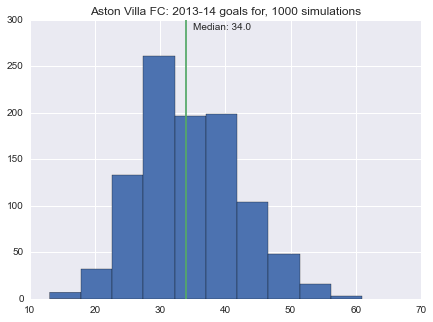

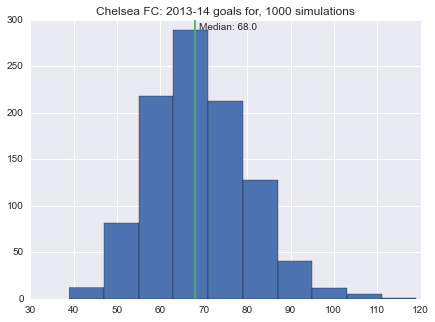

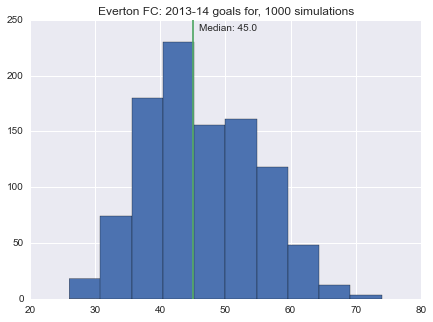

In [21]:
for team_code in teams.team.unique():
    plt.figure()
    ax = simuls.gf[simuls.team == team_code].hist(figsize=(7,5))
    median = simuls.gf[simuls.team == team_code].median()
    team_id = team_index[teams[teams.team == team_code].i.values[0]]
    team = get_team_by_id(team_id)
    ax.set_title(team.name + ': 2013-14 goals for, 1000 simulations')
    ax.plot([median, median], ax.get_ylim())
    plt.annotate('Median: %s' % median, xy=(median + 1, ax.get_ylim()[1]-10))

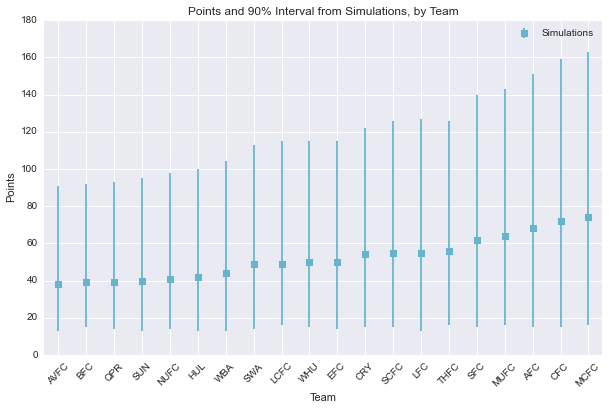

In [22]:
g = simuls.groupby('team')
season_hdis = pd.DataFrame({
                            'points_lower': g.points.quantile(.05),
                            'points_median': g.points.median(),
                            'points_upper': g.points.quantile(.95),
                            'goals_for_lower': g.gf.quantile(.05),
                            'goals_for_median': g.gf.median(),
                            'goals_for_upper': g.gf.quantile(.95),
                            'goals_against_lower': g.ga.quantile(.05),
                            'goals_against_upper': g.ga.quantile(.95),
                            })
column_order = ['points_lower', 'points_median', 'points_upper', 
                'goals_for_lower', 'goals_for_median', 'goals_for_upper',
                'goals_against_lower', 'goals_against_upper',]
season_hdis = season_hdis[column_order]
season_hdis['relative_goals_upper'] = season_hdis.goals_for_upper - season_hdis.goals_for_median
season_hdis['relative_goals_lower'] = season_hdis.goals_for_median - season_hdis.goals_for_lower
season_hdis = season_hdis.sort_index(by='points_median')
season_hdis = season_hdis.reset_index()
season_hdis['x'] = season_hdis.index + .5
season_hdis

fig, axs = plt.subplots(figsize=(10,6))
axs.errorbar(season_hdis.x, season_hdis.points_median, 
             yerr=(season_hdis[['points_lower', 'points_upper']].values).T, 
             fmt='s', c=sns.palettes.color_palette()[5], label='Simulations')
axs.set_title('Points and 90% Interval from Simulations, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Points')
axs.set_xlim(0, 20)
axs.legend()
_= axs.set_xticks(season_hdis.index + .5)
_= axs.set_xticklabels(season_hdis['team'].values, rotation=45)